<html id="* graph_euler_method">
	<author>Hiroshi TAKEMOTO</author>
	(<email>take.pwave@gmail.com</email>)
	
	<h1>Sageでグラフを再現してみよう：階層ベイズ法</h1>
	<p>
		この企画は、雑誌や教科書にでているグラフをSageで再現し、
		グラフの意味を理解すると共にSageの使い方をマスターすることを目的としています。
	</p>
	<p>
		今回は、<a href="http://www.amazon.co.jp/dp/4534046472">道具としてのベイズ統計</a>
		のp196の学生のテスト結果を階層ベイズ法を使って表現した図を題材にします。
	</p>
	<p>
		<img src="images/fig1.png"/>
	</p>
</html>

<html>
	<h2>前準備</h2>
	<p>
		最初に必要なライブラリーやパッケージをロードしておきます。
	</p>
</html>

In [1]:
# RとPandasのデータフレームを相互に変換する関数を読み込む
# Rの必要なライブラリ
r('library(ggplot2)')
r('library(jsonlite)')

# python用のパッケージ
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline

# jupyter用のdisplayメソッド
from IPython.display import display, Latex, HTML, Math, JSON
# sageユーティリティ
load('script/sage_util.py')
# Rユーティリティ
load('script/RUtil.py')

<html>
	<h2>データの度数分布</h2>
	<p>
		学生のテスト結果は、１０点満点中、Xのような得点になっています。
	</p>
	<p>
		これまで、度数分布図はRを使っていましたが、点数毎のカウント数を保持する辞書型変数を
		plot関数に渡すと度数分布が表示されることが分かりました。
	</p>
</html>

In [2]:
X = [1, 0, 10, 4, 10, 10, 10, 6, 4, 10, 1, 9, 0, 5, 10, 7, 1, 9, 2, 8]
N = len(X)
r(X).name('X')
r(N).name('N')

[1] 20

<html>
	<h3>度数を計算する関数_mkHist</h3>
	<p>
		度数を計算する関数_mkHistを以下のように定義します。
		処理は、データの値毎にカウント数をアップしているだけです。
		ポイントとしては、hist.setdefaultを使って要素が未定義
		の場合に、0をデフォルト値としているところです。
	</p>
	<p>
		作成した度数分布図をhist_plt変数に保持しておきます。
	</p>
</html>

In [3]:
# 度数分布の作成
def _mkHist(data):
    hist = {}
    for k in data:
        hist.setdefault(k,0)
        hist[k] += 1
    return hist

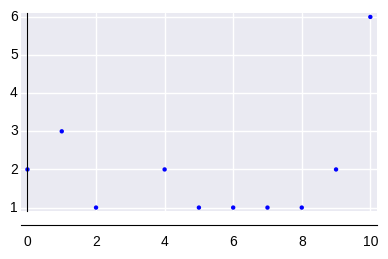

In [4]:
# Xの度数分布を表示
hist_plt = list_plot(_mkHist(X), zorder=2)
hist_plt.show(figsize=4)

<html>
	<h2>階層ベイズ計算プログラムJAGSをRから使う</h2>
	<p>
		階層ベイズのギブス・サンプリングを行うプログラムJAGSをRから使うためのライブラリ
		を呼び込みます。
	</p>
	<p>
		rjagsについては、singular piont氏の「
		<a href="http://www.singularpoint.org/blog/r/mcmc-jags-1/">JAGSを使ってギブスサンプリングを試してみた </a>
		」を参考にしました。
	</p>
</html>

In [5]:
#r("install.packages('coda')")
#r("install.packages('rjags', version='3.15', dependencies=TRUE)")
r('library(rjags)')

 [1] "rjags"     "coda"      "jsonlite"  "ggplot2"   "stats"     "graphics"  "grDevices" "utils"    
 [9] "datasets"  "methods"   "base"     

<html>
	<h2>二項分布の場合</h2>
	<p>
		学生の持つ問題解決能力をq（皆同じ値と仮定）とすると、i番目の学生が１０点満点中k点を取る確率$p_i$は以下のようになります。
$$
		p_i = {}_{10} C_k q^k (1 - q)^{10 - k}
$$		
	</p>
</html>
<html>
	<h3>jagsモデル定義</h3>
	<p>
		jagsのモデルファイルは、とても簡単です。
	</p>
	<p>
		i番目の学生得点は、dbin(q, 10)に比例し、
$$
		x_i \sim dbin(q, 10)
$$	
		問題解決能力をqは、一様分布dunif(0, 1)に比例すると仮定します。
$$
		q \sim dunif(0, 1)
$$			
	</p>
	<p>
		これをJAGSのモデルで記述すると、以下のようになります。（とてもストレートで読みやすいと思いませんか）
	</p>
</html>

In [6]:
%%writefile data/ex_5.jags
model {
    for (i in 1:N) {
        x[i] ~ dbin(q, 10)            
    }
    q ~ dunif(0,1)
}

Overwriting data/ex_5.jags


<html>
	<h3>jagsモデルの作成</h3>
	<p>
		上記のモデルを使ってjagsのモデルオブジェクトを生成します。
	</p>
	<p>
		dataとして、学生の得点Xとサンプル数Nを渡します。
	</p>
	<p>
		n.chainsで４つのチェインを指定し、n.adapt=1000で稼働検査期間(buring in period)を1000と指定します。
	</p>
</html>

In [7]:
# mcmcモデルの作成
junk = r('mcmc.model <- jags.model("data/ex_5.jags", data=list("x"=X,"N"=N), n.chains=4,   n.adapt=1000)')

<html>
	<h3>mcmcサンプリング</h3>
	<p>
		サンプリングには、jagsをそのまま使うのではなく、codaを使ってサンプリングを行います。
		これによって、サンプリング後の収束判定や変数の分布図のプロット等がとても簡単になります。
	</p>
	<p>
		coda.samplesの引数で、サンプリングする変数名qとサンプリング数1000を指定します。
	</p>
</html>

In [8]:
# サンプリング（途中経過が出力されるので、junkで吸収）
junk = r('mcmc.sample <- coda.samples(mcmc.model, c("q"), 1000)')

<html>
	<h3>サンプリング結果の出力</h3>
	<p>
		summary関数を使ってサンプリング結果を出力します。
	</p>
	<p>
		qの平均値が0.5837391、qの標準偏差が0.0349724と求まっています。
	</p>
</html>

In [9]:
# 出力結果
r('summary(mcmc.sample)')


Iterations = 1:1000
Thinning interval = 1 
Number of chains = 4 
Sample size per chain = 1000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

          Mean             SD       Naive SE Time-series SE 
     0.5838555      0.0347887      0.0005501      0.0005257 

2. Quantiles for each variable:

  2.5%    25%    50%    75%  97.5% 
0.5145 0.5607 0.5837 0.6070 0.6533 


<html>
	<h3>変数の収束状態と分布図の出力</h3>
	<p>
		変数の収束を数値で判断する場合には、codaのgelman.plot等を使いますが、
		ここでは、plot関数でqのサンプルリング状況とqの密度分布を表示してその収束
		具合を表示します。（pdfからpngへの変換に時間がかかるためグラフの例はこれだけにします）
	</p>
</html>

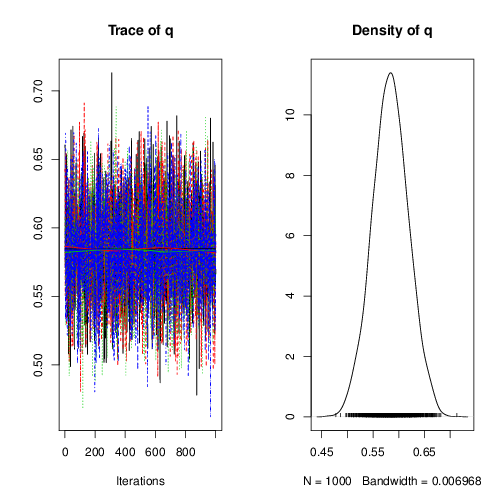

In [10]:
# グラフ表示（変換時間がかかる）
graph = preGraph('images/ex5_q.pdf')
r('plot(mcmc.sample)')
postGraph(graph)

<html>
	<h3>計算結果をsageに返す方法</h3>
	<p>
		jagsの計算結果をsageに戻すには、sageobj関数を使用してsummary結果を
		sageに渡します。
	</p>
	<p>
		summaryをsageobjに変換した結果を見やすくしたもの以下に示します。
	</p>
	<p>
		DATAの中のstatistics辞書に含まれるDATAが結果であることが分かりました。
		これを使ってqの統計情報をq_statに代入しています。
	</p>
</html>

In [11]:
# 統計情報をSageに戻る方法
summary = sageobj(r('summary(mcmc.sample)'))

In [12]:
summary

{'DATA': {'end': 1000,
  'nchain': 4,
  'quantiles': {'DATA': [0.514490020509135,
    0.560679874496162,
    0.583723358170264,
    0.606952806527294,
    0.653261601057],
   '_Names': ['2.5%', '25%', '50%', '75%', '97.5%']},
  'start': 1,
  'statistics': {'DATA': [0.58385552580395,
    0.034788658624687,
    0.000550056989980358,
    0.000525669302561606],
   '_Names': ['Mean', 'SD', 'Naive SE', 'Time-series SE']},
  'thin': 1},
 '_Names': ['statistics', 'quantiles', 'start', 'end', 'thin', 'nchain'],
 '_r_class': 'summary.mcmc'}

In [13]:
# summaryからqに関する統計情報を抽出
q_stat = summary['DATA']['statistics']['DATA']; q_stat

[0.58385552580395,
 0.034788658624687,
 0.000550056989980358,
 0.000525669302561606]

<html>
	<h3>二項分布図</h3>
	<p>
		jagsを使ったギブス・サンプリングで求まったqを使って学生の得点確率pの確率分布を表示してみます。
	</p>
	<p>
		_pで二項分布を定義し、0から10までの得点の確率分布(赤の線)を以下に示します。
	</p>
	<p>
		学生の問題解決能力をqを一定としたために、分布が学生の得点分布をうまく表現できていません。
	</p>
</html>

In [14]:
# 二項分布を定義
def _p(q, x):
    return binomial(10, x)*q^x*(1-q)^(10-x)

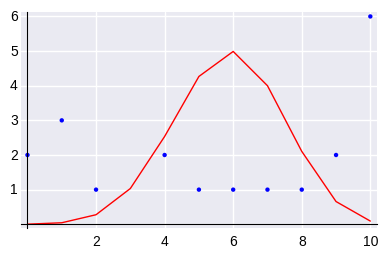

In [15]:
# pの確率分布をプロット
q = q_stat[0]
p_plt = list_plot([_p(q, x)*N for x in (0..10)], plotjoined=True, rgbcolor="red")
(hist_plt + p_plt).show(figsize=4)

<html>
	<h2>個人の学習能力を考慮したモデル</h2>
	<p>
		そこで、個人の学習能力にばらつきがあると仮定したモデルを作成します。
	</p>
	<p>
		学生iの問題解決能力を$q_i$とし、$q_i$が以下の学習曲線で変化すると仮定します。
	</p>
	<p>
		この学習曲線をロジットモデルと呼び、以下の式で表されます。
$$
		log\frac{q_i}{1 - q_i} = \beta + \gamma_i
$$		
	</p>
	<p>
		学生の問題解決能力は、クラスの全体の平均的な理解度合い$\beta$とそれからのずれ
		$\gamma_i$（これを個人の理解度と呼ぶことにしましょう）
	</p>
</html>

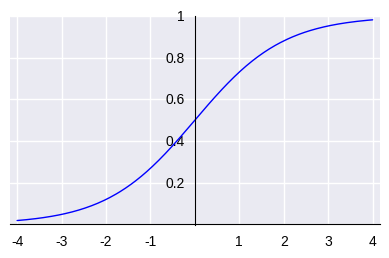

In [16]:
# 個人差を考慮した階層ベイズモデル
# 学習曲線(成長曲線と本では紹介)
var('x')
plot(1/(1 + e^(-x)), [x, -4, 4]).show(figsize=4)

<html>
	<h3>ハイパーパラメータ</h3>
	<p>
		個人の理解度正規分布を持つと仮定し、この事前分布$\pi(\gamma_i | \sigma)$を以下のように定義します。
$$
		\pi(\gamma_i | \sigma) \sim \mathcal{N}(\gamma_i, \sigma)
$$		
	</p>
	<p>
		また、$\beta$も正規分布を持つと仮定し、$\sigma$は逆ガンマ分布従うと仮定します。		
	</p>
	<p>
		残念ながらjagsには逆ガンマ分布が提供されていないため、$\tau$のガンマ分布を使って
		モデルを作成します。
$$
		\tau = \frac{1}{\sigma^2}
$$	
	</p>
	<p>
		$\tau$の初期分布として、$\gamma(x, 0.1, 0.1)$を使います。
		これは、かなり一定値に近い分布となります。
	</p>
</html>

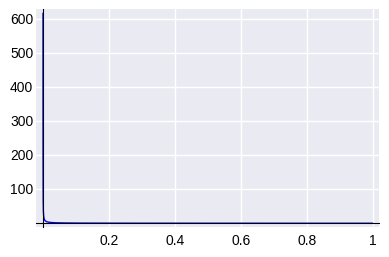

In [17]:
# σ^2には限りなく一定に近いγ(x, 0.1, 0.1)を使用
Ga(x, a, lam) = x^(a-1)*e^(-lam*x)*lam^a/gamma(a)
plot(lambda x: Ga(x, 0.1, 0.1), [x, 0, 1]).show(figsize=4)

<html>
	<h3>個人の学習能力を考慮したモデルのjagsモデル</h3>
	<p>
		個人の学習能力を考慮した階層ベイズモデルをjagsの形式で以下に定義します。
	</p>
	<p>
		x_hat, x_mean, x_sdは、平均の収束度合いを計算するためにチェック用に定義しています。
	</p>
</html>

In [18]:
%%writefile data/ex_6.jags
model {
    for (i in 1:N) {
        x[i] ~ dbin(q[i], 10)
        logit(q[i]) <- beta + gam[i]
        gam[i] ~ dnorm(0, tau)
        # add for check
        x_hat[i] ~ dbin(q[i], 10)
    }
    beta ~ dnorm(0, 0.0001)
    tau ~ dgamma(0.1, 0.1)
    # add for check
    x_mean <- mean(x_hat)
    x_sd <- sd(x_hat)
}

Overwriting data/ex_6.jags


<html>
	<h3>個人の学習能力を考慮したモデル実行</h3>
	<p>
		先ほどと同様にjagsモデルを作成し、サンプリングを実行します。
	</p>
	<p>
		サンプリングで取り出すのは、x_mean, x_sd, q, beta, tauとします。
	</p>
</html>

In [19]:
# mcmcモデルの作成
junk = r('mcmc.model <- jags.model("data/ex_6.jags", data=list("x"=X,"N"=N), n.chains=4, n.adapt=1000)')

In [20]:
# サンプリング（途中経過が出力されるので、junkで吸収）
junk = r('mcmc.sample <- coda.samples(mcmc.model, c("x_mean", "x_sd", "q", "beta","tau"), 4000)')

<html>
	<h3>計算結果</h3>
	<p>
		計算結果は、先ほどとは異なり、24x4のマトリックスとして返されます。
	</p>
	<p>
		それをsageのbeta, q, tau, x_mean, x_sdにセットしています。
	</p>
	<p>
		x_meanが5.84929375、x_sdが3.79893738478という値は、
		実データの平均5.9と標準偏差3.80とよく一致しています。
	</p>
</html>

In [21]:
# 出力結果（）
# r('summary(mcmc.sample)')

In [22]:
# summaryからx_mean, x_sd, tau, betaを取り出す
summary = sageobj(r('summary(mcmc.sample)'))
stat = summary['DATA']['statistics']; stat

24 x 4 dense matrix over Real Double Field (use the '.str()' method to see the entries)

In [23]:
# 結果を変数にセット
vals = stat.column(0).list()
beta = vals[0]
q = vals[1:21]
tau = vals[21]
x_mean = vals[22]
x_sd = vals[23]
print x_mean, x_sd, beta, tau
print q

5.8496625 3.90080927524 0.911430402062 0.0996895973171
[0.131847137525641, 0.0460888891423977, 0.966227574796758, 0.410937138520737, 0.965358858506929, 0.965203322553168, 0.965358462473892, 0.605169408206735, 0.41447668617391, 0.965078601878168, 0.130231103796037, 0.884874646490626, 0.0466880809742211, 0.507878709050931, 0.966355936883709, 0.698121225811493, 0.130500176198087, 0.886112404377343, 0.223037946063444, 0.792454698689964]


<html>
	<h3>期待得点分布</h3>
	<p>
		個人の理解度$\gamma$を持つ学生が得点xを取る確率は、以下のようになります。
$$
		f(\beta, \sigma, \gamma | x) = {}_{10} C_x q^x (1 - q)^{10-x} \frac{1}{\sqrt{2 \pi}\sigma} e^{- \frac{\gamma^2}{2 \sigma^2}}
$$	
	</p>
	<p>
		これを$\gamma$で積分したものが、学生が得点xを取る確率になります。
$$
		f(\beta, \sigma | x) = \int f(\beta, \sigma, \gamma | x) d \gamma
$$	
	</p>
	<p>
		sage$f(\beta, \sigma, \gamma | x)$を関数_r(x, b, r, sig)に定義します。
	</p>
	<p>
		また、x=0~10までの各分布を以下にプロットします。プロットの結果から分布の積分を求めるには、
		-20から20の範囲で数値積分すれば良いことが読み取れます。
	</p>
</html>

In [24]:
# f(beta, sig, r | x)の定義
sig = sqrt(1/tau)
def _r(x, b, r, sig):
    q = 1/(1+e^(-b-r))
    return binomial(10, x)*q^x*(1-q)^(10-x)*1/(sqrt(2*pi)*sig)*e^(-r^2/(2*sig*sig))

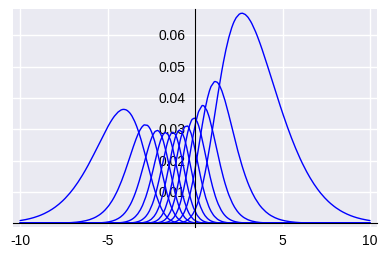

In [25]:
# f(beta, sig, r | x)のプロット
plts = Graphics()
for x in (0..10):
    plts += plot(lambda r : _r(x, beta, r, sig), [r, -10, 10])
plts.show(figsize=4)

<html>
	<h3>$f(\beta, \sigma | x)$を求める</h3>
	<p>
		Sageの最大の武器はその数式処理能力です、ここでは数値積分関数(numerical_integral)を
		使って$f(\beta, \sigma, \gamma | x)$を数値積分します。	
	</p>
</html>

In [26]:
# γの周辺確率を求める
# f(beta, sig | x) = integral f(beta, sig, r | x) dr
def _rInt(x, b, sig):
    (s, e) = numerical_integral(lambda r : _r(x, beta, r, sig), -20, 20)
    return s

<html>
	<h3>求める図のプロット</h3>
	<p>
		ようやく求める図をプロットするのに必要な道具が揃いました。
	</p>
	<p>
		数値積分は、_rInt関数で行い、xが0から10までの$f(\beta, \sigma, \gamma | x)$の
		値をプロットし、度数分布図と重ねて表示したのが、以下の図です。
	</p>
	<p>
		このようにSageとjagsの組み合わせによって通常の処理形では難しい階層ベイズ推定を
		使ったモデルの解析がとても簡単にできることがご理解頂けと思います。
	</p>
	<p>
		これを機会に是非Sageとjagsを使ってみてください。
	</p>
</html>

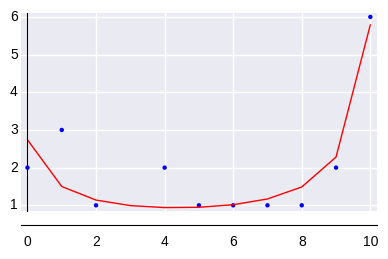

In [27]:
r_plt = list_plot([_rInt(x, beta, sig)*N for x in (0..10)], plotjoined=True, rgbcolor="red")
(hist_plt + r_plt).show(figsize=4)